In [1]:
import os, subprocess, re, traceback, sys
from glob import glob
import ants
import nibabel as nib
from nilearn import plotting
from nipype.interfaces import fsl
import matplotlib.pyplot as plt
import shutil
import pandas as pd
import numpy as np
%matplotlib inline


# global settings
base_path = '/mnt/data_lab513/vqtran_data'
root_data = os.path.join(base_path, "data", "raw_data", "ADNI_NIfTI")
root_bias_correction = os.path.join(base_path, "data", "clean_data", "mri_bias_correction")
root_bet = os.path.join(base_path, "data", "clean_data", "mri_brain_extraction")
root_reg = os.path.join(base_path, "data", "clean_data", "mri_registration")
root_meta = os.path.join(base_path, "data", "meta_data")#, "Pre-Thesis_metadata", "ADNI") 
root_train = os.path.join(base_path, "data", "train_data")
root_numpy_array = os.path.join(base_path, "data", 'data_numpy_array')
root_model = os.path.join(base_path, 'Model')
#print(os.listdir(root_meta))

#CREATE DATA DIRECTORY FOR READING DATA TO MODEL
CN_path = os.path.join(root_train, "CN")
EMCI_path = os.path.join(root_train, "EMCI")
LMCI_path = os.path.join(root_train, "LMCI")
AD_path = os.path.join(root_train, "AD")


/home/vqtran/miniconda3/envs/anhHuy/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning:

Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.



In [2]:
csv_table_dir = os.path.join(root_meta, "Pre-Thesis_5_21_2021_ADNI.csv")
df = pd.read_csv(csv_table_dir)

#df.head()
df.tail()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
2085,I15948,002_S_0559,CN,M,79,1,MRI,MP-RAGE,Original,5/23/2006,DCM,NaN
2086,I240812,002_S_0413,CN,F,82,26,MRI,MPRAGE,Original,6/16/2011,DCM,11/22/2020
2087,I14437,002_S_0413,CN,F,76,1,MRI,MP-RAGE,Original,5/02/2006,DCM,2/22/2020
2088,I238627,002_S_0295,CN,M,90,26,MRI,MPRAGE,Original,6/02/2011,DCM,11/22/2020
2089,I13722,002_S_0295,CN,M,85,1,MRI,MP-RAGE,Original,4/18/2006,DCM,2/25/2020


**Loading data and preprocessing**

In [30]:
import nibabel as nib
from numpy import ndarray
from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min_value = ndarray.min(volume) #-1000
    max_value = ndarray.max(volume) #400
    volume[volume < min_value] = min_value
    volume[volume > max_value] = max_value
    volume = (volume - min_value) / (max_value - min_value)
    volume = volume.astype("float32")
    return volume


def resize_volume(img, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = TARGET_DEPTH
    desired_width = TARGET_WIDTH
    desired_height = TARGET_HEIGHT
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    #img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img



process_scan_count = 0


def process_scan(path, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT)
    
    global process_scan_count
    process_scan_count += 1
    if (process_scan_count % 100) == 0:
        print(process_scan_count)
    
    return volume

**READ CT SCAN FROM CLASS DIRECTORY**

In [31]:

def check_data_leakage(filename):
    """ return true if the subject of the filename have not been encountered (no data leakage)
        else return false
    """
    #path = os.path.join(dirname, filename)
    
    #id_image= filename[filename.index('_I')+1 : filename.index('.n')]
    #print(id_image)        
                
    id_subject = filename[5:15]
    #print(id_subject)
    
    global subject_checklist
    if id_subject not in subject_checklist:
        subject_checklist.append(id_subject)
        return True
    else:     
        return False

In [32]:
subject_checklist = []
DATA_LEAKAGE_OPT = False
if DATA_LEAKAGE_OPT:
    # Folder "CT-0" consist of CT scans having normal lung tissue,
    # no CT-signs of viral pneumonia.
    CN_scan_paths = [
        os.path.join(CN_path, x)
        for x in os.listdir(CN_path) 
    ]
    # Folder "CT-23" consist of CT scans having several ground-glass opacifications,
    # involvement of lung parenchyma.
    EMCI_scan_paths = [
        os.path.join(EMCI_path, x)
        for x in os.listdir(EMCI_path)
    ]

    LMCI_scan_paths = [
        os.path.join(LMCI_path, x)
        for x in os.listdir(LMCI_path)
    ]

    AD_scan_paths = [
        os.path.join(AD_path, x)
        for x in os.listdir(AD_path)
    ]
else:
    # Folder "CT-0" consist of CT scans having normal lung tissue,
    # no CT-signs of viral pneumonia.
    CN_scan_paths = [
        os.path.join(CN_path, x)
        for x in os.listdir(CN_path) 
        if check_data_leakage(x)
    ]
    # Folder "CT-23" consist of CT scans having several ground-glass opacifications,
    # involvement of lung parenchyma.
    EMCI_scan_paths = [
        os.path.join(EMCI_path, x)
        for x in os.listdir(EMCI_path)
        if check_data_leakage(x)
    ]

    LMCI_scan_paths = [
        os.path.join(LMCI_path, x)
        for x in os.listdir(LMCI_path)
        if check_data_leakage(x)
    ]

    AD_scan_paths = [
        os.path.join(AD_path, x)
        for x in os.listdir(AD_path)
        if check_data_leakage(x)
    ]


print("MRI scans with NC label: " + str(len(CN_scan_paths)))
print("MRI scans with EMCI label: " + str(len(EMCI_scan_paths)))
print("MRI scans with LMCI label: " + str(len(LMCI_scan_paths )))
print("MRI scans with AD label: " + str(len(AD_scan_paths)))

MRI scans with NC label: 349
MRI scans with EMCI label: 238
MRI scans with LMCI label: 139
MRI scans with AD label: 279


In [33]:
len(CN_scan_paths) + len(EMCI_scan_paths) + len(LMCI_scan_paths ) + len(AD_scan_paths)

1005

**Build train and validation datasets**

In [34]:
TARGET_DEPTH = 182
TARGET_WIDTH = 182
TARGET_HEIGHT = 218
part = 4
DATA_LEAKAGE_OPT = False
TRAIN_ON_SUBSET = True
DATA_PARTITION_RATIO = 0.2
# number of training samples:
num_CN_samples = len(CN_scan_paths)  
num_EMCI_samples = len(EMCI_scan_paths)  
num_LMCI_samples = len(LMCI_scan_paths)  
num_AD_samples = len(AD_scan_paths)  
num_all_samples = len(CN_scan_paths) + len(EMCI_scan_paths) + len(LMCI_scan_paths ) + len(AD_scan_paths)


# Read and process the scans.
if (TRAIN_ON_SUBSET):
    # Each scan is resized across height, width, and depth and rescaled
    CN_scans = np.array([process_scan(path, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT) for path in CN_scan_paths[part*int(DATA_PARTITION_RATIO*num_CN_samples):(part+1)*int(DATA_PARTITION_RATIO*num_CN_samples)]])
    EMCI_scans = np.array([process_scan(path, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT) for path in EMCI_scan_paths[part*int(DATA_PARTITION_RATIO*num_EMCI_samples):(part+1)*int(DATA_PARTITION_RATIO*num_EMCI_samples)]])
    LMCI_scans = np.array([process_scan(path, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT) for path in LMCI_scan_paths[part*int(DATA_PARTITION_RATIO*num_LMCI_samples):(part+1)*int(DATA_PARTITION_RATIO*num_LMCI_samples )]])
    AD_scans = np.array([process_scan(path, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT) for path in AD_scan_paths[part*int(DATA_PARTITION_RATIO*num_AD_samples):(part+1)*int(DATA_PARTITION_RATIO*num_AD_samples)]])
else:
    CN_scans = np.array([process_scan(path, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT) for path in CN_scan_paths])
    EMCI_scans = np.array([process_scan(path,TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT) for path in EMCI_scan_paths])
    LMCI_scans = np.array([process_scan(path, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT) for path in LMCI_scan_paths])
    AD_scans = np.array([process_scan(path, TARGET_DEPTH, TARGET_WIDTH, TARGET_HEIGHT) for path in AD_scan_paths])


print('part 1 ok')

# Label_dict = {"CN": 0, "EMCI": 1, "LMCI": 2, "AD": 3}
CN_labels = np.array([0 for _ in range(len(CN_scans))])
EMCI_labels = np.array([1 for _ in range(len(EMCI_scans))])
LMCI_labels = np.array([2 for _ in range(len(LMCI_scans))])
AD_labels = np.array([3 for _ in range(len(AD_scans))])

print('part 2 ok')



from sklearn.model_selection import train_test_split
TRAINVAL_TEST_RATIO = 0.2
TRAIN_VAL_RATIO = 0.25



all_data = np.concatenate((CN_scans, EMCI_scans, LMCI_scans, AD_scans), axis=0)
all_label = np.concatenate((CN_labels, EMCI_labels, LMCI_labels, AD_labels), axis=0)
    
print('part 3 ok')

x_train, x_test, y_train, y_test = train_test_split(all_data, all_label, test_size= TRAINVAL_TEST_RATIO, random_state=0, stratify=all_label)

del all_data
del all_label

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= TRAIN_VAL_RATIO, random_state=0, stratify=y_train)

print('part 4 ok')

print(
    "Number of samples in train, validation, and test set are %d, %d, and %d."
    % (x_train.shape[0], x_val.shape[0], x_test.shape[0])
)


100
part 1 ok
part 2 ok
part 3 ok
part 4 ok
Number of samples in train, validation, and test set are 118, 40, and 40.


In [35]:
#os.chdir(base_path)
#os.getcwd()
#os.listdir(base_path)
#os.chdir(os.path.join(base_path, "data"))
#os.listdir(os.path.join(base_path, "data"))
#os.mkdir(os.path.join(base_path, "data", "data_numpy_array")
#os.listdir(os.path.join(base_path, "data"))


**Save tensorflow dataset**

In [36]:
# ###Save and load numpy array in compressed format
# # save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
# define data
#data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
# save to npy file
if (TRAIN_ON_SUBSET): 
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'x_train_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), x_train)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'x_val_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), x_val)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'x_test_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), x_test)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'y_train_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), y_train)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'y_val_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), y_val)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'y_test_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), y_test)
else:
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'x_train_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), x_train)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'x_val_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), x_val)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'x_test_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), x_test)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'y_train_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), y_train)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'y_val_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), y_val)
    savez_compressed(os.path.join(base_path, "data", 'data_numpy_array', 'y_test_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'), y_test)
    
    
    

#https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/

**START HERE**

In [37]:
import os, subprocess, re, traceback, sys
from glob import glob
import ants
import nibabel as nib
from nilearn import plotting
from nipype.interfaces import fsl
import matplotlib.pyplot as plt
import shutil
import pandas as pd
import numpy as np
%matplotlib inline


# global settings
base_path = '/mnt/data_lab513/vqtran_data'
root_data = os.path.join(base_path, "data", "raw_data", "ADNI_NIfTI")
root_bias_correction = os.path.join(base_path, "data", "clean_data", "mri_bias_correction")
root_bet = os.path.join(base_path, "data", "clean_data", "mri_brain_extraction")
root_reg = os.path.join(base_path, "data", "clean_data", "mri_registration")
root_meta = os.path.join(base_path, "data", "meta_data")#, "Pre-Thesis_metadata", "ADNI") 
root_train = os.path.join(base_path, "data", "train_data")
root_numpy_array = os.path.join(base_path, "data", 'data_numpy_array')
root_model = os.path.join(base_path, 'Model')
#print(os.listdir(root_meta))

#CREATE DATA DIRECTORY FOR READING DATA TO MODEL
CN_path = os.path.join(root_train, "CN")
EMCI_path = os.path.join(root_train, "EMCI")
LMCI_path = os.path.join(root_train, "LMCI")
AD_path = os.path.join(root_train, "AD")

In [38]:
#os.chdir(base_path)
os.listdir(os.path.join(base_path,  'data', 'data_numpy_array'))

['x_val_subset.npz',
 'y_train_646464.npz',
 'x_test.npz',
 'x_test_110110110.npz',
 'x_test_646464.npz',
 'x_test_969664.npz',
 'x_test_969696.npz',
 'x_test_subset.npz',
 'x_test_subset_182218182.npz',
 'x_test_subset_182218182_0.npz',
 'x_test_subset_182218182_1.npz',
 'x_test_subset_182218182_2.npz',
 'x_test_subset_182218182_3.npz',
 'x_test_subset_182218182_4.npz',
 'x_test_subset_969664.npz',
 'x_train.npz',
 'x_train_110110110.npz',
 'x_train_646464.npz',
 'x_train_969664.npz',
 'x_train_969696.npz',
 'x_train_subset.npz',
 'x_train_subset_182218182.npz',
 'x_train_subset_182218182_0.npz',
 'x_train_subset_182218182_1.npz',
 'x_train_subset_182218182_2.npz',
 'x_train_subset_182218182_3.npz',
 'x_train_subset_182218182_4.npz',
 'x_train_subset_969664.npz',
 'x_val.npz',
 'x_val_110110110.npz',
 'x_val_646464.npz',
 'x_val_969664.npz',
 'x_val_969696.npz',
 'x_val_subset_182218182.npz',
 'x_val_subset_182218182_0.npz',
 'x_val_subset_182218182_1.npz',
 'x_val_subset_182218182_2.

In [39]:
# # load numpy array from npz file
from numpy import load
TRAIN_ON_SUBSET = True
""" #original code
if (TRAIN_ON_SUBSET):
    # # load dict of arrays
    dict_x_train = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_train_subset.npz'))
    dict_x_val = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_val_subset.npz'))
    dict_x_test = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_test_subset.npz'))
    dict_y_train = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_train_subset.npz'))
    dict_y_val = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_val_subset.npz'))
    dict_y_test = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_test_subset.npz'))
    
else:
    # # load dict of arrays
    dict_x_train = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_train.npz'))
    dict_x_val = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_val.npz'))
    dict_x_test = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_test.npz'))
    dict_y_train = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_train.npz'))
    dict_y_val = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_val.npz'))
    dict_y_test = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_test.npz'))
"""
    
if (TRAIN_ON_SUBSET): 
        dict_x_train = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_train_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_x_val = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_val_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_x_test = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_test_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_y_train = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_train_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_y_val = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_val_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_y_test = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_test_subset_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
    
else:
        dict_x_train = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_train_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_x_val = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_val_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_x_test = load(os.path.join(base_path, "data", 'data_numpy_array', 'x_test_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_y_train = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_train_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_y_val = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_val_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
        dict_y_test = load(os.path.join(base_path, "data", 'data_numpy_array', 'y_test_' + str(TARGET_WIDTH) + str(TARGET_HEIGHT) + str(TARGET_DEPTH) + '_' +str(part) +'.npz'))
    
# # extract the first array
# data = dict_data['arr_0']
x_train = dict_x_train['arr_0']
x_val = dict_x_val['arr_0']
x_test = dict_x_test['arr_0']
y_train = dict_y_train['arr_0']
y_val= dict_y_val['arr_0']
y_test = dict_y_test['arr_0']
# # print the array
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(118, 182, 218, 182)
(40, 182, 218, 182)
(40, 182, 218, 182)
(118,)
(40,)
(40,)


In [ ]:
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
         axes[i].imshow(slice.T, cmap="gray", origin="lower")

            
#img_data = np.squeeze(sample_img_data,3)
img_data = x_train[1]
slice_0 = img_data[img_data.shape[0]//2, :, :]
slice_1 = img_data[:, img_data.shape[1]//2, :]
slice_2 = img_data[:, :, img_data.shape[2]//2]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")  

**Data augmentation**

In [3]:
import random
import tensorflow as tf
from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

**Data Loader**

In [4]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 1
BUFFER_SIZE = 1

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(BATCH_SIZE)
    .prefetch(BUFFER_SIZE)
)

# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(BATCH_SIZE)
    .prefetch(BUFFER_SIZE)
)

# Only rescale.
test_dataset = (
    test_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(BATCH_SIZE)
    .prefetch(BUFFER_SIZE)
)


**Data visualization**

Dimension of the MRI scan is: (64, 64, 48, 1)


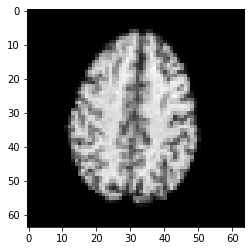

In [5]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

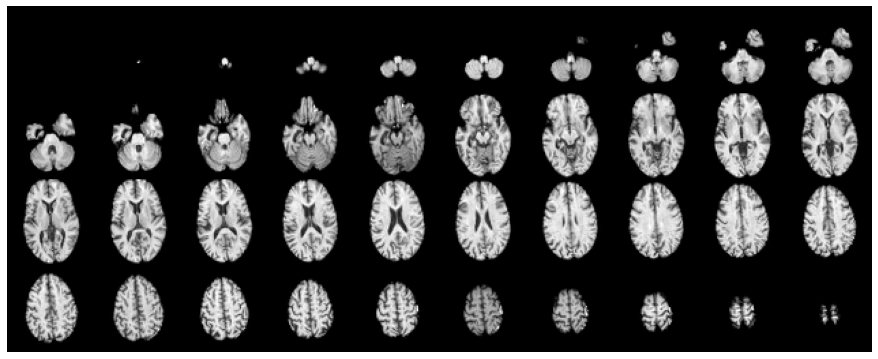

In [6]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
#plot_slices(4, 10, 128, 128, image[:, :, :40]) #for image dimension (128, 128, 96)
plot_slices(4, 10, x_train.shape[1], x_train.shape[2], image[:, :, :40])    #for image dimension (64, 64, 48)

**DEFINE MODEL ARCHITECTURE**

In [7]:
import tensorflow as tf


In [8]:
def get_model_example(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = tf.keras.Input((width, height, depth, 1))

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

#     x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
#     x = tf.keras.layers.BatchNormalization()(x)

#     x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
#     x = tf.keras.layers.BatchNormalization()(x)

#     x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
#     x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(units=4, activation="softmax")(x)

    # Define the model.
    model = tf.keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model_example(width=64, height=64, depth=48)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 48, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 62, 62, 46, 64)    1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 31, 31, 23, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 23, 64)    256       
_________________________________________________________________
global_average_pooling3d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               33280     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [9]:
def plain_block(previous_x, last_layer_stride, no_filter, add):
    
    x = tf.keras.layers.Conv3D(filters=no_filter, kernel_size=(3,3,3),padding = "same")(previous_x) #, padding = "same"
    x = tf.keras.layers.ReLU() (x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv3D(filters=no_filter, kernel_size=(3,3,3), padding = "same")(x) #, padding = "same", strides = last_layer_stride
    
    if add == True:
        x = tf.keras.layers.Add()([previous_x,x])
    else:
        skip_connection = tf.keras.layers.Conv3D(filters=no_filter, kernel_size=(3,3,3), padding = "same")(previous_x)
        skip_connection = tf.keras.layers.BatchNormalization()(skip_connection)
        x = tf.keras.layers.Add()([skip_connection,x])
        
    
    x = tf.keras.layers.ReLU() (x)
    x = tf.keras.layers.BatchNormalization()(x)
    if tf.keras.last_layer_stride > 1:
        x = tf.keras.layers.Conv3D(filters=no_filter, kernel_size=(1,1,1), strides = last_layer_stride, padding = "same")(x)
        
    return x


def create_3D_resnet_18_skip_conv(width=64, height=64, depth=48):
    inputs = tf.keras.Input((width, height, depth,1))
    x = tf.keras.layers.Conv3D(filters=16, kernel_size=(5,5,5), strides = 2, padding = 'same')(inputs)
    
    #conv2 x 3
    x = plain_block(x, last_layer_stride = 1, no_filter = 16, add = False)
    x = plain_block(x, last_layer_stride = 1, no_filter = 16, add = True)
    
    
    #conv3 x 4
    x = plain_block(x, last_layer_stride = 1, no_filter = 32,  add = False)
    x = plain_block(x, last_layer_stride = 1, no_filter = 32,  add = True)
    
    
    #conv4 x 6
    x = plain_block(x, last_layer_stride = 1, no_filter = 64,  add = False)
    x = plain_block(x, last_layer_stride = 1, no_filter = 64,  add = True)
    
    
    #conv5 x 4
    x = plain_block(x, last_layer_stride = 1, no_filter = 128, add = False)
    x = plain_block(x, last_layer_stride = 1, no_filter = 128, add = True)
    
    #Classification layers
    #x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.AveragePooling3D(pool_size=(3, 3, 2), strides=None, padding='valid', data_format=None) (x)
    
    #x = layers.GlobalAveragePooling3D()(x) #???
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=128, activation="relu")(x)
    #outputs = layers.Dense(units=1, activation="sigmoid")(x) 
    
    outputs = tf.keras.layers.Dense(units = 4, activation="softmax")(x)
    
    # Define the model.
    model = tf.keras.Model(inputs, outputs, name="3d_Resnet_18")
    return model

In [10]:
#model_3D_resnet_18 = create_3D_resnet_18_skip_conv(width=64, height=64, depth=48)
#model_3D_resnet_18.summary()


In [11]:
#tf.keras.utils.plot_model(model_3D_resnet_18, show_shapes = True, show_layer_names = True, rankdir="TB", expand_nested = True, dpi = 100) # ,show_dtype = True,to_file='model.png')

In [12]:
subject_checklist = []
def check_data_leakage(filename):
    """ return true if the subject of the filename have not been encountered (no data leakage)
        else return false
    """
    #path = os.path.join(dirname, filename)
    
    #id_image= filename[filename.index('_I')+1 : filename.index('.n')]
    #print(id_image)        
                
    id_subject = filename[5:15]
    #print(id_subject)
    
    global subject_checklist
    if id_subject not in subject_checklist:
        subject_checklist.append(id_subject)
        return True
    else:     
        return False
    
DATA_LEAKAGE_OPT = False #false mean no leakage
if DATA_LEAKAGE_OPT:
    # Folder "CT-0" consist of CT scans having normal lung tissue,
    # no CT-signs of viral pneumonia.
    CN_scan_paths = [
        os.path.join(CN_path, x)
        for x in os.listdir(CN_path) 
    ]
    # Folder "CT-23" consist of CT scans having several ground-glass opacifications,
    # involvement of lung parenchyma.
    EMCI_scan_paths = [
        os.path.join(EMCI_path, x)
        for x in os.listdir(EMCI_path)
    ]

    LMCI_scan_paths = [
        os.path.join(LMCI_path, x)
        for x in os.listdir(LMCI_path)
    ]

    AD_scan_paths = [
        os.path.join(AD_path, x)
        for x in os.listdir(AD_path)
    ]
else:
    # Folder "CT-0" consist of CT scans having normal lung tissue,
    # no CT-signs of viral pneumonia.
    CN_scan_paths = [
        os.path.join(CN_path, x)
        for x in os.listdir(CN_path) 
        if check_data_leakage(x)
    ]
    # Folder "CT-23" consist of CT scans having several ground-glass opacifications,
    # involvement of lung parenchyma.
    EMCI_scan_paths = [
        os.path.join(EMCI_path, x)
        for x in os.listdir(EMCI_path)
        if check_data_leakage(x)
    ]

    LMCI_scan_paths = [
        os.path.join(LMCI_path, x)
        for x in os.listdir(LMCI_path)
        if check_data_leakage(x)
    ]

    AD_scan_paths = [
        os.path.join(AD_path, x)
        for x in os.listdir(AD_path)
        if check_data_leakage(x)
    ]


print("MRI scans with NC label: " + str(len(CN_scan_paths)))
print("MRI scans with EMCI label: " + str(len(EMCI_scan_paths)))
print("MRI scans with LMCI label: " + str(len(LMCI_scan_paths )))
print("MRI scans with AD label: " + str(len(AD_scan_paths)))

num_CN_samples = len(CN_scan_paths)  
num_EMCI_samples = len(EMCI_scan_paths)  
num_LMCI_samples = len(LMCI_scan_paths)  
num_AD_samples = len(AD_scan_paths)
num_all_samples = num_CN_samples + num_EMCI_samples + num_LMCI_samples + num_AD_samples


"""
MRI scans with NC label: 349
MRI scans with EMCI label: 238
MRI scans with LMCI label: 139
MRI scans with AD label: 279
"""


MRI scans with NC label: 349
MRI scans with EMCI label: 238
MRI scans with LMCI label: 139
MRI scans with AD label: 279


In [13]:
# #Check tensorflow
# import tensorflow as tf
# print(tf.version.VERSION)
# config = tf.compat.v1.ConfigProto()

# config.gpu_options.allow_growth = True

# sess = tf.compat.v1.Session(config=config)

# #print(sess)
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print("GPU names: ", tf.config.list_physical_devices('GPU'))

In [14]:
# import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [15]:
#check similar with the above
TARGET_DEPTH = 48
TARGET_WIDTH = 64
TARGET_HEIGHT = 64


import tensorflow as tf
# from tensorflow.compat.v1.keras.backend import set_session
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True      # to log device placement (on which device the operation ran)
# sess = tf.compat.v1.Session(config=config)
# set_session(sess)



#Create a MirroredStrategy.
#strategy = tf.distribute.MirroredStrategy()
#print("Number of devices: {}".format(strategy.num_replicas_in_sync))


initial_learning_rate = 0.0001 #0.00001
epochs = 10

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate, decay_steps=1000, decay_rate=0.90, staircase=True)

class_weight = {0: (num_all_samples/ num_CN_samples),
                1: (num_all_samples/ num_EMCI_samples),
                2: (num_all_samples/ num_LMCI_samples),
                3: (num_all_samples/ num_AD_samples)}


# Open a strategy scope.
#with strategy.scope():
with tf.device('/device:GPU:0'):
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.


    #model = create_3D_resnet_18_skip_conv(width=TARGET_WIDTH, height=TARGET_HEIGHT, depth=TARGET_DEPTH)
    model = get_model_example(width=TARGET_WIDTH, height=TARGET_HEIGHT, depth=TARGET_DEPTH)
    
    model.compile(
        loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam'),
        metrics= tf.keras.metrics.SparseCategoricalAccuracy()) #["acc"]

# Train the model on all available devices.
#train_dataset, val_dataset, test_dataset = get_dataset()

#model.fit(train_dataset, epochs=5, validation_data=val_dataset)
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    
    verbose=1,
    class_weight=class_weight)
# Test the model on all available devices.
model.evaluate(test_dataset)

Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node 3dcnn/conv3d_1/Conv3D (defined at <ipython-input-15-a28bc9278106>:60) ]] [Op:__inference_train_function_1357]

Function call stack:
train_function


Shutdown kernel

In [ ]:
# import os

# pid = os.getpid()
# !kill -9 $pid

In [25]:
!pip show cuda
!pip show cudnn

Name: cuda
Version: 0.0.1
Summary: cuda
Home-page: https://github.com/007gzs/cuda
Author: 007gzs
Author-email: 007gzs@sina.com
License: LGPL v3
Location: /home/vqtran/miniconda3/envs/anhHuy/lib/python3.6/site-packages
Requires: 
Required-by: 


In [24]:
#!conda remove --force cudatookit
#!conda remove --force cudnn


# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

RuntimeError: Physical devices cannot be modified after being initialized

In [68]:
# Compile model.
#batch_size = 3             #Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches).
#validation_batch_size = 3  #Do not specify the validation_batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches).
initial_learning_rate = 0.0001 #0.00001
epochs = 10

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.90, staircase=True
)

#model = model_3D_skip #*** comment out this line for the keras network#
model = model_3D_resnet_18
model.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(), #from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam'),
    metrics=["acc"])
    #optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
    #keras.optimizers.Adam(learning_rate=lr_schedule),
    

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    os.path.join(root_model, "3DResNet18_lr0.0001.h5")
    , save_best_only=True
    , monitor='val_acc',verbose=1
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=30)

# Classweight
class_weight = {0: (num_all_samples/ num_CN_samples),
                1: (num_all_samples/ num_EMCI_samples),
                2: (num_all_samples/ num_LMCI_samples),
                3: (num_all_samples/ num_AD_samples)}
print("ok")


# Train the model, doing validation at the end of each epoch
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

ok
Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node 3d_Resnet_18/conv3d_168/Conv3D (defined at <ipython-input-68-c96ff5cf1898>:46) ]] [Op:__inference_train_function_142664]

Function call stack:
train_function


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
# Load best weights.
# This need to be fix

# model.load_weights("3d_image_classification.h5")
# prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
# scores = [1 - prediction[0], prediction[0]]

# class_names = ["CN", "EMCI", "LMCI", "AD"]
# for score, name in zip(scores, class_names):
#     print(
#         "This model is %.2f percent confident that CT scan is %s"
#         % ((100 * score), name)
#     )

**NEED**
1. Add Confusion matrix
2. Add AUC curve
3. Add GradCAM
4. Add output visualization
5. Move to .py file


In [44]:

#import tensorflow as tf
#!pip install tensorflow-gpu
!pip show cuda
!pip show cnDNN

**TEST MODEL**

In [ ]:
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# Only rescale.
test_dataset = (
    validation_loader.shuffle(len(x_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(buffer_size)
)